In [ ]:
#@title Import the necessary things and confs

! pip install -Uq timm
import timm

from pathlib import Path
import os

creds = '{"username":"sebasmanco","key":"a0f01aadb0e584b9c9aa0e8ebf5a2696"}'                        # credentials for kaggle APi 

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

     |████████████████████████████████| 549 kB 21.1 MB/s 
     |████████████████████████████████| 182 kB 21.0 MB/s 


Import the _fastai_ library which will help us with all that has to do with the competition, including the import of the data, the submission, etc... 



In [ ]:
from fastkaggle import *

comp = 'paddy-disease-classification'                                                               # The competition 
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')                                        # grab the data and install the necessary dependencies 
path

100%|██████████| 1.02G/1.02G [00:54<00:00, 20.0MB/s]


Path('paddy-disease-classification')

Now we can import all the necessary libraries such that numpy, pandas and matplotlib using _fastai_ and configure the style for the plots in the notebook. Next, import the vision library and set the seed for reproducibility.

In [ ]:
from fastai.imports import *
%config InlineBackend.figure_format = 'retina'

In [ ]:
from fastai.vision.all import *
set_seed(42)

path.ls()                                                                                           # see what are in the path 

(#4) [Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv')]

Import the training data from the selected path using `get_image_files` from _fastai_:

In [ ]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

Let's see one of the images:

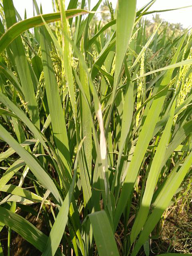

In [ ]:
img = PILImage.create(files[0])
img.to_thumb(256)

It's important to recognize what are the sizes of each of the images in the dataset, in this case, we can extract the size for all of these taking advenatage of the the _fastcore_ library and the parallel method:

In [ ]:
from fastcore.parallel import *

In [ ]:
def f(o) : return PILImage.create(o).size

sizes = parallel(f,files,n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

We can see that the great majority of the images have the same size except for a few ones; With this in mind, at the moment to create the data loaders we have to resize the images.


>In this case, we will resize the images by squishing them to a 480x480 square images, additionally, we will do some data augmentation over these. 

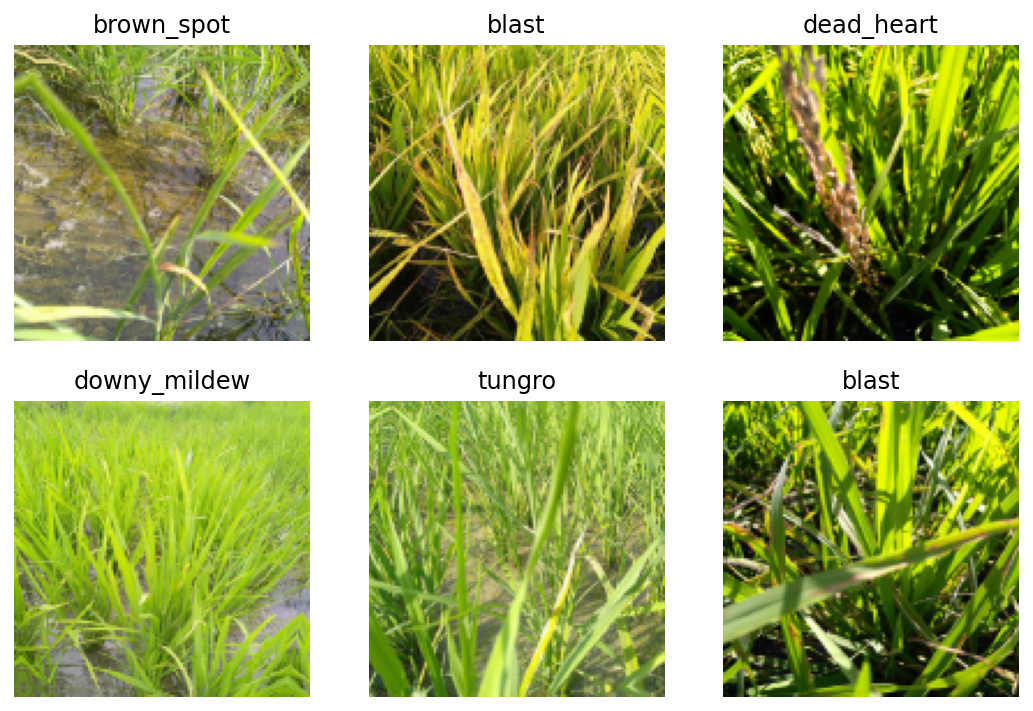

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,                                # training and validation sets 
                                   item_tfms=Resize(480, method='squish'),                          # Resize each image to 480x480 by squishing them 
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))             # Data augmentation for the images in the batch

dls.show_batch(max_n=6)

Definine the model using the `resnet26d` architecture and the `error_rate` as the metric:

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


> _fastai_ also provides us with a function that helps us to pick the learning rate for the training of the model: `lr_find`.



SuggestedLRs(valley=0.0005754399462603033, slide=0.002511886414140463)

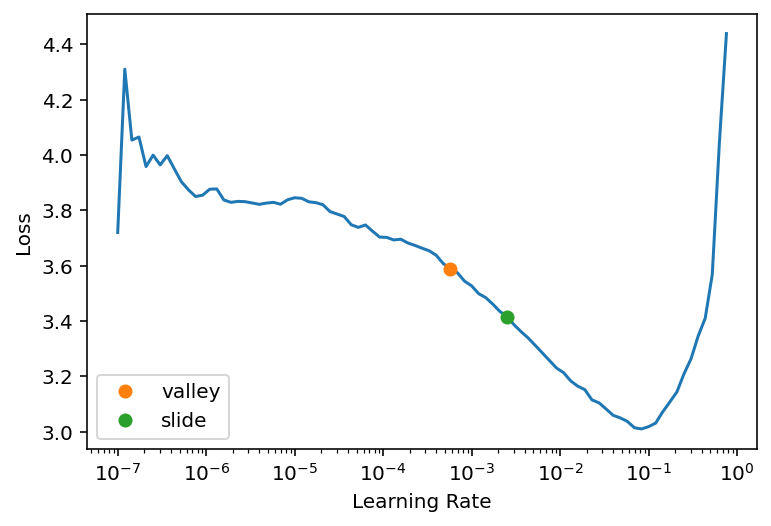

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

Train the model taking advantage of fine tunning, in this case with 4 epochs:

In [ ]:
learn.fine_tune(4, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.759427,1.286041,0.388275,01:42


epoch,train_loss,valid_loss,error_rate,time
0,1.132908,0.758772,0.236425,01:40
1,0.820773,0.525342,0.167708,01:51
2,0.566124,0.372384,0.110524,01:52
3,0.439394,0.366876,0.111004,01:42


With the model already trained, we can import the test set from the datasets of the competition:

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


Import the test set:

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

And get the predictions from the trained model, this predictions are shown as the indices corresponding to each of the diseases, these names are stored in the _fastai_ `vocab`:

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)                                        # return the indices corresponding to each of the diseases 
idxs

TensorBase([7, 8, 4,  ..., 8, 1, 5])

In [ ]:
dls.vocab                                                                                           # see the correponding diseases 

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

Now we have to assign each disease its corresponding index:

In [ ]:
mapping = dict(enumerate(dls.vocab))                                                                
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

Create the submission file with our predictions:

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,brown_spot
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


And export it to kaggle:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial_2 rn26d 128px', comp)

100%|██████████| 70.1k/70.1k [00:02<00:00, 30.1kB/s]


In [ ]:
if not iskaggle:
    push_notebook('sebasmanco ', 'Paddy Disease competition',
                  title='Paddy Disease competition',
                  file='/content/drive/MyDrive/fast.ai/lesson6.ipynb',
                  competition=comp, private=True, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/sebasmanco/paddy-disease-competition
